## Tanzania Power Flow Analysis

In [5]:
import pandas as pd
from io import StringIO
import pandapower as pp

# ===========================
# 1. Define Bus Data
# ===========================

bus_data = """bus_name\tvn_kv\tgeodata
Arusha\t220\t(-3.3869, 36.682)
Manyara\t220\t(-4.1884, 35.7589)
Dar es salaam\t220\t(-6.7924, 39.2083)
Pwani\t220\t(-6.331, 38.456)
Dodoma\t400\t(-6.163, 35.7516)
Iringa\t400\t(-7.7667, 35.7)
Mbeya\t220\t(-8.9092, 33.4608)
Morogoro\t220\t(-6.8278, 37.6591)
Mwanza\t220\t(-2.5164, 32.9172)
Shinyanga\t220\t(-3.661, 33.4233)
Singida\t220\t(-4.8161, 34.7436)
Tabora\t220\t(-5.0162, 32.8266)
Tanga\t220\t(-5.30, 38.6)
Zanzibar\t220\t(-6.163, 39.2584)
JNHPP\t400\t(-7.803, 37.85)
Kilimanjaro\t220\t(-3.96, 37.77)
Geita\t220\t(-2.87, 32.17)
"""

buses = pd.read_csv(StringIO(bus_data), sep="\t")
buses['Latitude'] = buses['geodata'].str.extract(r'\((-?\d+\.\d+),')[0].astype(float)
buses['Longitude'] = buses['geodata'].str.extract(r',\s*(-?\d+\.\d+)\)')[0].astype(float)
buses.drop(columns='geodata', inplace=True)


# ===========================
# 2. Create empty network and bus_map
# ===========================

net = pp.create_empty_network()
bus_map = {}

for _, row in buses.iterrows():
    bus_map[row['bus_name']] = pp.create_bus(net, vn_kv=row['vn_kv'], name=row['bus_name'])


# ===========================
# ===========================
# 3. Add Custom Line Types
# 3. Add Custom Line Types
# ===========================

# Base parameters
bluejay_params = {
    "r_ohm_per_km": 0.05136,
    "x_ohm_per_km": 0.4,
    "c_nf_per_km": 12.0,
    "max_i_ka": 0.874,
    "type": "ol",
    "q_mm2": 565.5
}

zebra_params = {
    "r_ohm_per_km": 0.034,
    "x_ohm_per_km": 0.31,
    "c_nf_per_km": 13.0,
    "max_i_ka": 1.056,
    "type": "ol",
    "q_mm2": 485
}

# Create base types
pp.create_std_type(net, bluejay_params, name="ACSR_Bluejay", element="line")
pp.create_std_type(net, zebra_params, name="ACSR_Zebra", element="line")

# Create enhanced types to simulate 3 parallel Bluejay lines
bluejay_3x = {
    "r_ohm_per_km": bluejay_params["r_ohm_per_km"] / 3,
    "x_ohm_per_km": bluejay_params["x_ohm_per_km"] / 3,
    "c_nf_per_km": bluejay_params["c_nf_per_km"] * 3,
    "max_i_ka": bluejay_params["max_i_ka"] * 3,
    "type": "ol",
    "q_mm2": bluejay_params["q_mm2"] * 3
}
pp.create_std_type(net, bluejay_3x, name="ACSR_Bluejay_3x", element="line")


# ===========================
# 4. Define Line Data and Add Lines
# ===========================

lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "length_km": 220, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},

    # Enhanced 3x parallel Bluejay lines
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},

    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 80, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 22, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 220, "length_km": 216.5, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 220, "length_km": 228.9, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}
]

# ===========================
# 5. Add Transformer (only for voltage level changes)
# ===========================

# Define transformer type once
standard_tx = {
    "sn_mva": 315,
    "vn_hv_kv": 400,
    "vn_lv_kv": 220,
    "vk_percent": 12,
    "vkr_percent": 0.28,
    "pfe_kw": 0,
    "i0_percent": 0.1,
    "shift_degree": 0
}
pp.create_std_type(net, standard_tx, name="400/220kV_TX", element="trafo")

# Add lines or transformers based on voltage level match
for line in lines_data:
    from_bus = bus_map[line['from_bus']]
    to_bus = bus_map[line['to_bus']]

    from_kv = buses.loc[buses['bus_name'] == line['from_bus'], 'vn_kv'].values[0]
    to_kv = buses.loc[buses['bus_name'] == line['to_bus'], 'vn_kv'].values[0]

    if from_kv == to_kv:
        # Add line if voltages match
        pp.create_line(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=line['length_km'],
            std_type=line['cable_type'],
            name=f"Line_{line['from_bus']}_to_{line['to_bus']}"
        )
    else:
        # Add transformer if voltages differ
        hv_bus = from_bus if from_kv > to_kv else to_bus
        lv_bus = to_bus if from_kv > to_kv else from_bus

        pp.create_transformer(
            net,
            hv_bus=hv_bus,
            lv_bus=lv_bus,
            std_type="400/220kV_TX",
            name=f"TX_{line['from_bus']}_to_{line['to_bus']}"
        )
# ===========================
# 5. Add Generators and External Grid
# ===========================

gen_data = {
    "gen_name": ["JNHPP", "Morogoro", "Dodoma", "Kilimanjaro", "Dar es salaam"],
    "p_mw": [540, 420, 20, 5, 600]
}
gen_df = pd.DataFrame(gen_data)

for _, row in gen_df.iterrows():
    bus_idx = bus_map[row['gen_name']]
    if row['gen_name'] == "JNHPP":
        pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Slack_JNHPP")
    else:
        pp.create_gen(net, bus=bus_idx, p_mw=row['p_mw'], vm_pu=1.0, name=row['gen_name'])


# ===========================
# 6. Add Loads
# ===========================

load_data = {
    "bus_name": [
        "Arusha", "Manyara", "Dar es salaam", "Pwani", "Dodoma", "Iringa",
        "Kilimanjaro", "Mbeya", "Morogoro", "Mwanza", "Shinyanga",
        "Singida", "Tabora", "Tanga", "Zanzibar", "Geita"
    ],
    "vn_kv": [
        220, 220, 220, 220, 220, 400, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220
    ],
    "p_mw": [
        112, 13, 989, 44.6, 31.51, 33, 66, 20.28, 86, 35, 45, 23, 23, 116, 113.89, 26
    ],
    "q_mvar": [
        36.81, 4.27, 325.07, 14.66, 10.36, 10.85, 21.69, 6.66, 28.27, 11.5, 14.79,
        7.56, 7.56, 38.13, 37.43, 8.55
    ]
}
load_df = pd.DataFrame(load_data)

for _, row in load_df.iterrows():
    bus_idx = bus_map[row['bus_name']]
    pp.create_load(net, 
                   bus=bus_idx, 
                   p_mw=row['p_mw'], 
                   q_mvar=row['q_mvar'], 
                   name=f"Load_{row['bus_name']}")


# ===========================
# 7. Run Power Flow and Print Results
# ===========================

pp.runpp(net)


## Displaying Power Flow Analysis Results

In [10]:
import pandas as pd
from IPython.display import display

# Set float formatting to 4 decimal places
pd.set_option("display.precision", 4)

def style_no_color_with_wide_columns(df, wide_cols=None, force_wide_table=False):
    """
    Style dataframe with black borders, right-aligned text,
    set wider min-width for columns in wide_cols list.
    If force_wide_table=True, force the entire table to be wide and scrollable.
    """
    base_styles = [
        {'selector': 'th', 'props': [
            ('border', '1px solid black'),
            ('text-align', 'center'),
            ('padding', '6px'),
            ('font-weight', 'bold'),
            ('color', 'black'),
            ('background-color', 'white')
        ]},
        {'selector': 'td', 'props': [
            ('border', '1px solid black'),
            ('color', 'black'),
            ('background-color', 'white')
        ]}
    ]

    if wide_cols:
        for col in wide_cols:
            idx = df.columns.get_loc(col) + 1
            base_styles.append({'selector': f'th:nth-child({idx})', 'props': [('min-width', '120px')]})
            base_styles.append({'selector': f'td:nth-child({idx})', 'props': [('min-width', '120px')]})

    if force_wide_table:
        table_style = ("border-collapse: collapse; "
                       "width: max-content; "
                       "min-width: 1600px; "
                       "overflow-x: auto; "
                       "display: block;")
    else:
        table_style = "border-collapse: collapse; width: 100%; overflow-x: auto;"

    return (df.style
            .set_table_attributes(f"style='{table_style}'")
            .set_properties(**{
                'border': '1px solid black',
                'text-align': 'right',
                'padding': '6px',
                'color': 'black',
                'background-color': 'white'
            })
            .set_table_styles(base_styles))


# --- 1. LINE RESULTS ---
line_columns = [
    "p_from_mw", "q_from_mvar",
    "p_to_mw", "q_to_mvar",
    "pl_mw", "ql_mvar",
    "i_from_ka", "i_to_ka", "i_ka",
    "vm_from_pu", "va_from_degree",
    "vm_to_pu", "va_to_degree",
    "loading_percent"
]
df_line = net.res_line[line_columns]

# Force line results table to be wide and scrollable
styled_line = style_no_color_with_wide_columns(df_line, wide_cols=line_columns, force_wide_table=True)


# --- 2. BUS RESULTS ---
bus_columns = ["p_mw", "q_mvar","va_degree", "vm_pu"]
df_bus = net.res_bus[bus_columns]
styled_bus = style_no_color_with_wide_columns(df_bus)


# --- 3. GENERATOR RESULTS ---
gen_columns = ["p_mw", "q_mvar", "va_degree", "vm_pu"]
df_gen = net.res_gen[gen_columns]
styled_gen = style_no_color_with_wide_columns(df_gen)


# --- 4. TRANSFORMER RESULTS ---
transformer_columns = [
    "p_hv_mw", "q_hv_mvar",
    "p_lv_mw", "q_lv_mvar",
    "loading_percent",
    "vm_hv_pu", "va_hv_degree",
    "vm_lv_pu", "va_lv_degree"
]
df_trafo = net.res_trafo[transformer_columns]
styled_trafo = style_no_color_with_wide_columns(df_trafo)


# --- DISPLAY ALL ---
print(" Line Results")
display(styled_line)

print("\n Bus Results")
display(styled_bus)

print("\n Generator Results")
display(styled_gen)

print("\n Transformer Results")
display(styled_trafo)


 Line Results


,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,299.373358,-53.694336,-296.287453,13.102647,3.085905,-40.591689,0.438431,0.428072,0.438431,1.001306,-24.939421,1.000000,-29.568794,50.163706
1,35.160429,-16.516013,-35.000000,-11.500000,0.160429,-28.016013,0.095147,0.090420,0.095147,1.071444,-50.076600,1.069253,-52.125362,10.886431
2,-503.893647,116.253172,508.566460,-106.406557,4.672813,9.846615,1.357115,1.372129,1.372129,1.000000,-31.126577,0.993741,-27.088519,52.331399
3,-737.535824,110.192757,754.027244,-26.360907,16.491420,83.831850,1.969340,1.980017,1.980017,0.993741,-27.088519,1.000000,-17.212403,75.515531
4,184.369363,-18.446199,-177.975834,36.508134,6.393530,18.061935,0.489322,0.476791,0.489322,0.993741,-27.088519,1.000000,-42.683188,55.986553
5,116.975834,35.062757,-116.000000,-38.130000,0.975834,-3.067243,0.320476,0.328989,0.328989,1.000000,-42.683188,0.974030,-45.945158,37.641807
6,23.133794,-34.596781,-23.000000,-7.560000,0.133794,-42.156781,0.101938,0.058378,0.101938,1.071444,-50.076600,1.088370,-52.125113,11.663359
7,126.910116,38.333652,-125.356566,-40.201120,1.553549,-1.867468,0.349022,0.360192,0.360192,0.996828,-35.806429,0.959151,-40.608386,41.211898
8,112.356566,35.931120,-112.000000,-36.810000,0.356566,-0.878880,0.322754,0.325856,0.325856,0.959151,-40.608386,0.949474,-41.838246,37.283247
9,114.893647,33.880807,-113.890000,-37.430000,1.003647,-3.549193,0.314354,0.323367,0.323367,1.000000,-31.126577,0.972923,-34.548531,36.998525



 Bus Results


,p_mw,q_mvar,va_degree,vm_pu
0,112.000000,36.810000,-41.838246,0.949474
1,13.000000,4.270000,-40.608386,0.959151
2,389.000000,-150.133979,-31.126577,1.000000
3,44.600000,14.660000,-27.088519,0.993741
4,11.510000,-30.437707,-29.568794,1.000000
5,33.000000,10.850000,-24.939421,1.001306
6,20.280000,6.660000,-25.378584,0.998496
7,-334.000000,-121.791868,-17.212403,1.000000
8,35.000000,11.500000,-52.125362,1.069253
9,45.000000,14.790000,-50.076600,1.071444



 Generator Results


,p_mw,q_mvar,va_degree,vm_pu
0,420.000000,150.061868,-17.212403,1.000000
1,20.000000,40.797707,-29.568794,1.000000
2,5.000000,93.260891,-42.683188,1.000000
3,600.000000,475.203979,-31.126577,1.000000



 Transformer Results


,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,loading_percent,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,-352.657440,35.694543,353.771308,12.343632,112.379992,1.001306,-24.939421,1.000000,-17.212403
1,20.284082,7.149793,-20.280000,-6.660000,6.818806,1.001306,-24.939421,0.998496,-25.378584
2,779.284797,99.559575,-773.798552,135.809143,249.405102,1.000000,0.000000,1.000000,-17.212403
3,284.777453,17.335059,-284.053914,13.978379,90.572882,1.000000,-29.568794,0.996828,-35.806429


## Filtering Results for Grid Resilience Assessment

In [17]:
import pandas as pd
import numpy as np
from IPython.display import display

# --- Line Table (Ignore voltage, only check overload) ---
line_loading = net.res_line.loading_percent.values

line_status = ["Overload" if load > 90 else "Normal" for load in line_loading]

line_df = pd.DataFrame({
    'From Bus': net.line.from_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.line.to_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': np.abs(net.res_bus.vm_pu.loc[net.line.from_bus].values - 
                                  net.res_bus.vm_pu.loc[net.line.to_bus].values).round(4),
    'Loading (%)': pd.Series(line_loading).round(1),
    'Connection Type': 'Line',
    'Status': line_status
})

# --- Transformer Table (Ignore voltage, only check overload) ---
trafo_loading = net.res_trafo.loading_percent.values

trafo_status = ["Overload" if load > 90 else "Normal" for load in trafo_loading]

trafo_df = pd.DataFrame({
    'From Bus': net.trafo.hv_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.trafo.lv_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': np.abs(net.res_bus.vm_pu.loc[net.trafo.hv_bus].values - 
                                  net.res_bus.vm_pu.loc[net.trafo.lv_bus].values).round(4),
    'Loading (%)': pd.Series(trafo_loading).round(1),
    'Connection Type': 'Transformer',
    'Status': trafo_status
})

# --- Combine Line and Transformer Tables ---
combined_df = pd.concat([line_df, trafo_df], ignore_index=True)

# --- Bus Voltage Table ---
bus_voltage = net.res_bus.vm_pu.round(4)
bus_names = net.bus['name']

bus_status = ["Voltage Violation" if v < 0.95 or v > 1.05 else "Normal" for v in bus_voltage]

bus_df = pd.DataFrame({
    'Bus Name': bus_names,
    'Voltage (p.u.)': bus_voltage,
    'Status': bus_status
})

# --- Display Function ---
def style_table(df, numeric_format={}):
    return (
        df.style
        .set_table_attributes("style='border-collapse: collapse; width: 100%;'")
        .set_properties(**{
            'border': '1px solid black',
            'text-align': 'right',
            'padding': '4px',
            'color': 'black',
            'background-color': 'white'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('border', '1px solid black'),
                ('text-align', 'center'),
                ('padding', '6px'),
                ('font-weight', 'bold'),
                ('color', 'black'),
                ('background-color', 'white')
            ]}
        ])
        .format(numeric_format)
    )

# --- Display Tables ---
print("Line and Transformer Summary:")
display(style_table(combined_df, {'Voltage Drop (p.u.)': '{:.4f}', 'Loading (%)': '{:.1f}'}))

print("\nBus Voltage Status:")
display(style_table(bus_df, {'Voltage (p.u.)': '{:.4f}'}))


Line and Transformer Summary:


,From Bus,To Bus,Voltage Drop (p.u.),Loading (%),Connection Type,Status
0,Iringa,Dodoma,0.0013,50.2,Line,Normal
1,Shinyanga,Mwanza,0.0022,10.9,Line,Normal
2,Dar es salaam,Pwani,0.0063,52.3,Line,Normal
3,Pwani,Morogoro,0.0063,75.5,Line,Normal
4,Pwani,Kilimanjaro,0.0063,56.0,Line,Normal
5,Kilimanjaro,Tanga,0.0260,37.6,Line,Normal
6,Shinyanga,Tabora,0.0169,11.7,Line,Normal
7,Singida,Manyara,0.0377,41.2,Line,Normal
8,Manyara,Arusha,0.0097,37.3,Line,Normal
9,Dar es salaam,Zanzibar,0.0271,37.0,Line,Normal



Bus Voltage Status:


,Bus Name,Voltage (p.u.),Status
0,Arusha,0.9495,Voltage Violation
1,Manyara,0.9592,Normal
2,Dar es salaam,1.0000,Normal
3,Pwani,0.9937,Normal
4,Dodoma,1.0000,Normal
5,Iringa,1.0013,Normal
6,Mbeya,0.9985,Normal
7,Morogoro,1.0000,Normal
8,Mwanza,1.0693,Voltage Violation
9,Shinyanga,1.0714,Voltage Violation


In [15]:
import pandas as pd
import numpy as np
from IPython.display import display

# --- Table 1: Lines and Transformers ---

# Voltage drops and line status
voltage_drop = np.abs(net.res_bus.vm_pu.loc[net.line.from_bus].values - net.res_bus.vm_pu.loc[net.line.to_bus].values)
line_loading = net.res_line.loading_percent.values
vm_from = net.res_bus.vm_pu.loc[net.line.from_bus].values
vm_to = net.res_bus.vm_pu.loc[net.line.to_bus].values

line_status = []
for v_from, v_to, load in zip(vm_from, vm_to, line_loading):
    status = []
    if v_from < 0.95 or v_from > 1.05 or v_to < 0.95 or v_to > 1.05:
        status.append("Voltage Violation")
    if load > 90:
        status.append("Overload")
    line_status.append(" ".join(status) if status else "Normal")

line_df = pd.DataFrame({
    'From Bus': net.line.from_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.line.to_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(voltage_drop).round(4),
    'Loading (%)': pd.Series(line_loading).round(1),
    'Connection Type': 'Line',
    'Status': line_status
})

# Transformer drops and status
trafo_vdrops = []
trafo_status = []
trafo_loading = net.res_trafo.loading_percent.values
vm_hv = net.res_bus.vm_pu.loc[net.trafo.hv_bus].values
vm_lv = net.res_bus.vm_pu.loc[net.trafo.lv_bus].values

for v_hv, v_lv, load in zip(vm_hv, vm_lv, trafo_loading):
    drop = abs(v_hv - v_lv)
    trafo_vdrops.append(drop)
    status = []
    if v_lv < 0.95 or v_lv > 1.05:
        status.append("Voltage Violation")
    if load > 90:
        status.append("Overload")
    trafo_status.append(" ".join(status) if status else "Normal")

trafo_df = pd.DataFrame({
    'From Bus': net.trafo.hv_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.trafo.lv_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(trafo_vdrops).round(4),
    'Loading (%)': pd.Series(trafo_loading).round(1),
    'Connection Type': 'Transformer',
    'Status': trafo_status
})

combined_df = pd.concat([line_df, trafo_df], ignore_index=True)

# --- Table 2: Bus Voltage Status ---

bus_voltage = net.res_bus.vm_pu.round(4)
bus_names = net.bus['name']

bus_status = ["Voltage Violation" if v < 0.95 or v > 1.05 else "Normal" for v in bus_voltage]

bus_df = pd.DataFrame({
    'Bus Name': bus_names,
    'Voltage (p.u.)': bus_voltage,
    'Status': bus_status
})

# --- Style and Display ---

def style_table(df, numeric_format={}):
    return (
        df.style
        .set_table_attributes("style='border-collapse: collapse; width: 100%;'")
        .set_properties(**{
            'border': '1px solid black',
            'text-align': 'right',
            'padding': '4px',
            'color': 'black',
            'background-color': 'white'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('border', '1px solid black'),
                ('text-align', 'center'),
                ('padding', '6px'),
                ('font-weight', 'bold'),
                ('color', 'black'),
                ('background-color', 'white')
            ]}
        ])
        .format(numeric_format)
    )

# Display styled tables
print("Line and Transformer Summary:")
display(style_table(combined_df, {'Voltage Drop (p.u.)': '{:.4f}', 'Loading (%)': '{:.1f}'}))

print("\n Bus Voltage Status:")
display(style_table(bus_df, {'Voltage (p.u.)': '{:.4f}'}))


Line and Transformer Summary:


,From Bus,To Bus,Voltage Drop (p.u.),Loading (%),Connection Type,Status
0,Iringa,Dodoma,0.0013,50.2,Line,Normal
1,Shinyanga,Mwanza,0.0022,10.9,Line,Voltage Violation
2,Dar es salaam,Pwani,0.0063,52.3,Line,Normal
3,Pwani,Morogoro,0.0063,75.5,Line,Normal
4,Pwani,Kilimanjaro,0.0063,56.0,Line,Normal
5,Kilimanjaro,Tanga,0.0260,37.6,Line,Normal
6,Shinyanga,Tabora,0.0169,11.7,Line,Voltage Violation
7,Singida,Manyara,0.0377,41.2,Line,Normal
8,Manyara,Arusha,0.0097,37.3,Line,Voltage Violation
9,Dar es salaam,Zanzibar,0.0271,37.0,Line,Normal



 Bus Voltage Status:


,Bus Name,Voltage (p.u.),Status
0,Arusha,0.9495,Voltage Violation
1,Manyara,0.9592,Normal
2,Dar es salaam,1.0000,Normal
3,Pwani,0.9937,Normal
4,Dodoma,1.0000,Normal
5,Iringa,1.0013,Normal
6,Mbeya,0.9985,Normal
7,Morogoro,1.0000,Normal
8,Mwanza,1.0693,Voltage Violation
9,Shinyanga,1.0714,Voltage Violation


In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import ast
from io import StringIO

# --- Step 1: Load Bus Coordinates ---
bus_df = pd.read_csv(StringIO(bus_data), sep='\t')
bus_df['Latitude'] = bus_df['geodata'].apply(lambda x: ast.literal_eval(x)[0])
bus_df['Longitude'] = bus_df['geodata'].apply(lambda x: ast.literal_eval(x)[1])
bus_coords = bus_df.set_index('bus_name')[['Latitude', 'Longitude']]

def get_coords(bus_name):
    try:
        return bus_coords.loc[bus_name]['Latitude'], bus_coords.loc[bus_name]['Longitude']
    except KeyError:
        return None, None

# --- Step 2: Add Coordinates and vm_pu to Buses ---
net.bus['Latitude'] = net.bus['name'].apply(lambda x: get_coords(x)[0])
net.bus['Longitude'] = net.bus['name'].apply(lambda x: get_coords(x)[1])
net.bus['vm_pu'] = net.res_bus.vm_pu

buses_with_coords = net.bus.dropna(subset=['Latitude', 'Longitude']).copy()

gdf_buses = gpd.GeoDataFrame(
    buses_with_coords,
    geometry=gpd.points_from_xy(buses_with_coords.Longitude, buses_with_coords.Latitude),
    crs="EPSG:4326"
)

gdf_buses = gdf_buses.rename(columns={'name': 'bus_name', 'vn_kv': 'volt'})
gdf_buses = gdf_buses[['bus_name', 'volt', 'vm_pu', 'geometry']]

# --- Step 3: Create Line GeoDataFrame ---
lines_df = net.line[['from_bus', 'to_bus']].copy()
lines_df['from_bus_name'] = lines_df['from_bus'].map(net.bus['name'])
lines_df['to_bus_name'] = lines_df['to_bus'].map(net.bus['name'])
lines_df['vm_from_pu'] = net.res_bus.vm_pu.loc[lines_df['from_bus']].values
lines_df['vm_to_pu'] = net.res_bus.vm_pu.loc[lines_df['to_bus']].values
lines_df['loading_percent'] = net.res_line.loading_percent.values

lines_df['from_lat'] = lines_df['from_bus_name'].apply(lambda x: get_coords(x)[0])
lines_df['from_lon'] = lines_df['from_bus_name'].apply(lambda x: get_coords(x)[1])
lines_df['to_lat'] = lines_df['to_bus_name'].apply(lambda x: get_coords(x)[0])
lines_df['to_lon'] = lines_df['to_bus_name'].apply(lambda x: get_coords(x)[1])

lines_df = lines_df.dropna(subset=['from_lat', 'from_lon', 'to_lat', 'to_lon']).copy()

lines_df['geometry'] = lines_df.apply(
    lambda r: LineString([(r['from_lon'], r['from_lat']), (r['to_lon'], r['to_lat'])]),
    axis=1
)

gdf_lines = gpd.GeoDataFrame(lines_df, geometry='geometry', crs='EPSG:4326')

gdf_lines = gdf_lines.rename(columns={
    'from_bus_name': 'from_b',
    'to_bus_name': 'to_b',
    'vm_from_pu': 'vm_fr_pu',
    'vm_to_pu': 'vm_to_pu',
    'loading_percent': 'load_pct'
})

gdf_lines = gdf_lines[['from_b', 'to_b', 'vm_fr_pu', 'vm_to_pu', 'load_pct', 'geometry']]

# --- Step 4: Create Transformer GeoDataFrame ---
trafo_df = pd.DataFrame({
    'from_bus': net.trafo.hv_bus.map(net.bus['name']),
    'to_bus': net.trafo.lv_bus.map(net.bus['name']),
    'vm_hv_pu': net.res_bus.vm_pu.loc[net.trafo.hv_bus].values,
    'vm_lv_pu': net.res_bus.vm_pu.loc[net.trafo.lv_bus].values,
    'loading_percent': net.res_trafo.loading_percent.values,
})

trafo_df['from_lat'] = trafo_df['from_bus'].apply(lambda x: get_coords(x)[0])
trafo_df['from_lon'] = trafo_df['from_bus'].apply(lambda x: get_coords(x)[1])
trafo_df['to_lat'] = trafo_df['to_bus'].apply(lambda x: get_coords(x)[0])
trafo_df['to_lon'] = trafo_df['to_bus'].apply(lambda x: get_coords(x)[1])

trafo_df = trafo_df.dropna(subset=['from_lat', 'from_lon', 'to_lat', 'to_lon']).copy()

trafo_df['geometry'] = trafo_df.apply(
    lambda r: LineString([(r['from_lon'], r['from_lat']), (r['to_lon'], r['to_lat'])]),
    axis=1
)

gdf_trafo = gpd.GeoDataFrame(trafo_df, geometry='geometry', crs='EPSG:4326')

gdf_trafo = gdf_trafo.rename(columns={
    'from_bus': 'from_b',
    'to_bus': 'to_b',
    'vm_hv_pu': 'vm_hv_pu',
    'vm_lv_pu': 'vm_lv_pu',
    'loading_percent': 'load_pct'
})

gdf_trafo = gdf_trafo[['from_b', 'to_b', 'vm_hv_pu', 'vm_lv_pu', 'load_pct', 'geometry']]

# --- Step 5: Export to Shapefiles ---
gdf_buses.to_file('buses.shp')
gdf_lines.to_file('lines.shp')
gdf_trafo.to_file('transformers.shp')

print("✅ Buses, lines, and transformers shapefiles with voltage/loading data exported successfully!")


✅ Buses, lines, and transformers shapefiles with voltage/loading data exported successfully!


## Visualization by using Map

In [11]:
import geopandas as gpd

tanzania_gdf = gpd.read_file('tanzania.shp')


In [13]:
pip install matplotlib-scalebar


Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install contextily


Note: you may need to restart the kernel to use updated packages.


## Final Grid Vulnerability Map

/var/folders/g3/t0kvm7d92yz4d6h3xvq1x1bw0000gn/T/ipykernel_38737/3637183534.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_voltage = plt.cm.get_cmap('coolwarm')


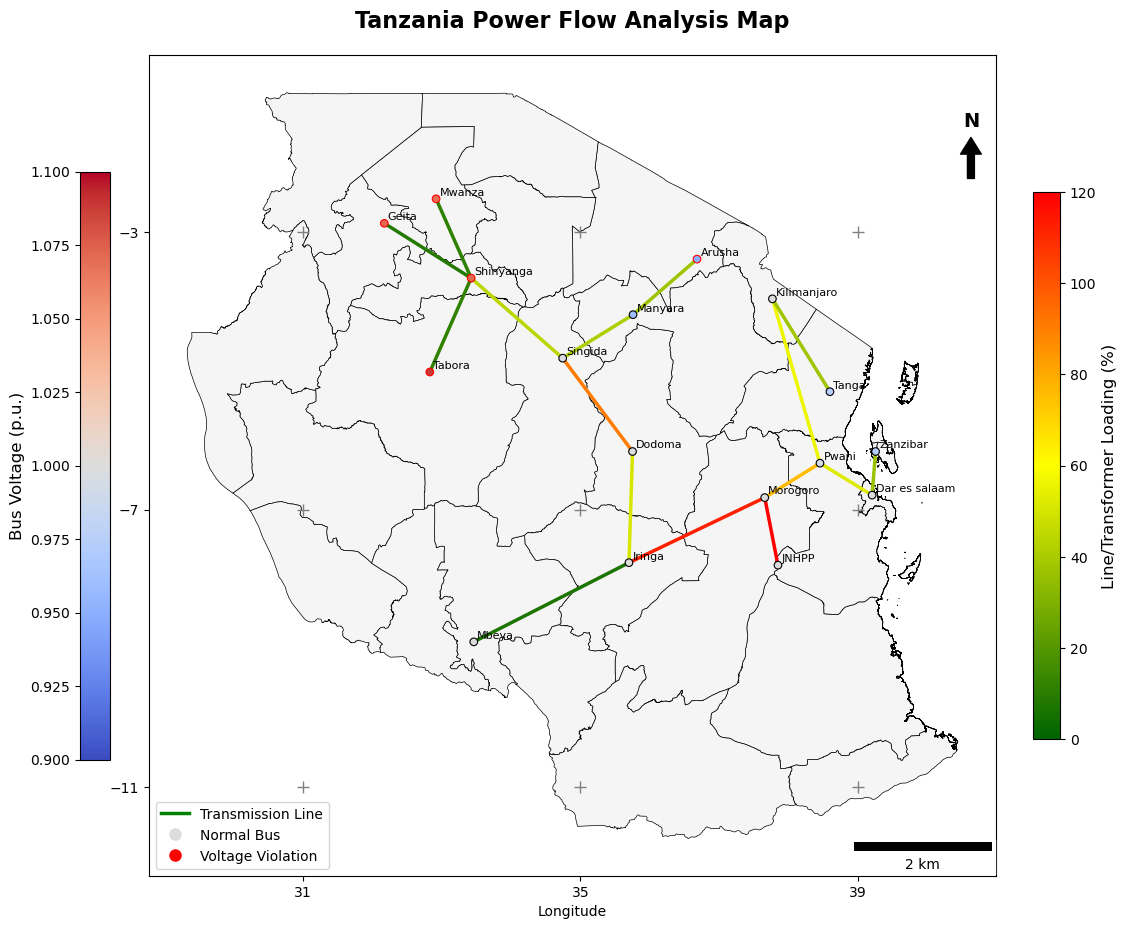

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point
import contextily as ctx

# Load data
tanzania_gdf = gpd.read_file('tanzania.shp')
gdf_buses = gpd.read_file('buses.shp')
gdf_lines = gpd.read_file('lines.shp')
gdf_trafo = gpd.read_file('transformers.shp')

# Define CRS
crs = tanzania_gdf.crs

# Voltage color map
norm_voltage = mcolors.Normalize(vmin=0.9, vmax=1.1)
cmap_voltage = plt.cm.get_cmap('coolwarm')
gdf_buses['color_b'] = gdf_buses['vm_pu'].apply(norm_voltage).apply(cmap_voltage)
gdf_buses['status'] = gdf_buses['vm_pu'].apply(lambda x: '⚠️ Violation' if (x < 0.95 or x > 1.05) else 'Normal')
gdf_buses['violation_color'] = gdf_buses['status'].apply(lambda s: 'red' if s != 'Normal' else 'black')

# Loading color map
colors = ['darkgreen', 'yellow', 'red']
cmap_loading = mcolors.LinearSegmentedColormap.from_list('green_red', colors, N=256)
norm_loading = mcolors.Normalize(vmin=0, vmax=120)
gdf_lines['color_l'] = gdf_lines['load_pct'].apply(norm_loading).apply(cmap_loading)
gdf_trafo['color_l'] = gdf_trafo['load_pct'].apply(norm_loading).apply(cmap_loading)

# Scalar mappables
sm_voltage = plt.cm.ScalarMappable(norm=norm_voltage, cmap=cmap_voltage)
sm_loading = plt.cm.ScalarMappable(norm=norm_loading, cmap=cmap_loading)

# Create plot
fig, ax = plt.subplots(figsize=(14, 16))
tanzania_gdf.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.5)

# Plot transmission lines with fixed width
gdf_lines.apply(lambda row: ax.plot(
    [row.geometry.coords[0][0], row.geometry.coords[1][0]],
    [row.geometry.coords[0][1], row.geometry.coords[1][1]],
    color=row['color_l'], linewidth=2.5, alpha=1.0, linestyle='-'), axis=1)

# Plot transformers with fixed width
gdf_trafo.apply(lambda row: ax.plot(
    [row.geometry.coords[0][0], row.geometry.coords[1][0]],
    [row.geometry.coords[0][1], row.geometry.coords[1][1]],
    color=row['color_l'], linewidth=2.5, alpha=1.0, linestyle='-'), axis=1)

# Plot buses
gdf_buses.plot(ax=ax, markersize=30, color=gdf_buses['color_b'], edgecolor=gdf_buses['violation_color'], linewidth=0.8, zorder=3)

# Annotate bus names
for x, y, label in zip(gdf_buses.geometry.x, gdf_buses.geometry.y, gdf_buses['bus_name']):
    ax.text(x + 0.05, y + 0.05, label, fontsize=8, color='black')

# Add colorbars
plt.colorbar(sm_voltage, ax=ax, fraction=0.03, pad=0.04, orientation='vertical', shrink=0.8, location='left').set_label("Bus Voltage (p.u.)", fontsize=12)
plt.colorbar(sm_loading, ax=ax, fraction=0.03, pad=0.04, orientation='vertical', shrink=0.8, location='right').set_label("Line/Transformer Loading (%)", fontsize=12)

# Custom legend
legend_lines = [
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label='Transmission Line'),
    mlines.Line2D( [], [], color=cmap_voltage(norm_voltage(1.0)),  # Same blue from colormap at 1.0 p.u.
    marker='o', linestyle='', markersize=8, label='Normal Bus'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='', markersize=8, label='Voltage Violation')
]
ax.legend(handles=legend_lines, loc='lower left', fontsize=10, frameon=True)

# Define custom grid marks (only 3 x 3 = 9 points)
x_ticks = np.linspace(31, 39, 3)  # Longitude marks: e.g., 31, 35, 39
y_ticks = np.linspace(-3, -11, 3)   # Latitude marks: e.g., 3, 7, 11

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Plot grid marks at intersections
for x in x_ticks:
    for y in y_ticks:
        ax.plot(x, y, marker='+', color='grey', markersize=8)


# Add scale bar
scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right')
ax.add_artist(scalebar)

# Add north arrow as symbol
arrow_x, arrow_y = 0.97, 0.90
ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - 0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center')

ax.text(arrow_x, arrow_y + 0.02, 'N', transform=ax.transAxes,
        ha='center', va='center', fontsize=14, fontweight='bold')

# Layout and title
ax.set_title("Tanzania Power Flow Analysis Map" , fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal', adjustable='box')

plt.subplots_adjust(left=0.15, right=0.85)  # Custom margins
plt.show()



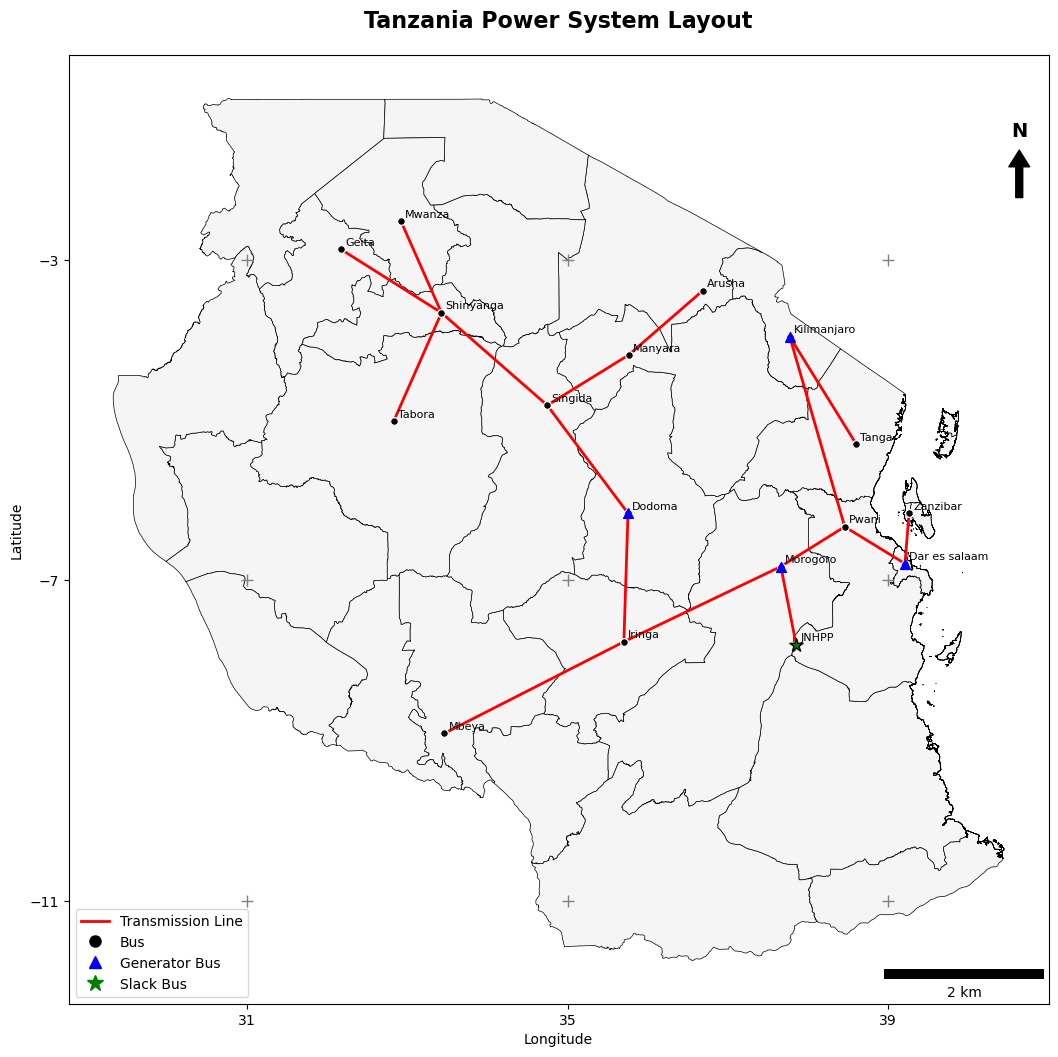

In [35]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import numpy as np

# Load shapefiles
tanzania_gdf = gpd.read_file('tanzania.shp')
gdf_buses = gpd.read_file('buses.shp')
gdf_lines = gpd.read_file('lines.shp')
gdf_trafo = gpd.read_file('transformers.shp')

gen_name = ['Morogoro', 'Dodoma', 'Kilimanjaro', 'Dar es salaam']
gdf_gen_buses = gdf_buses[gdf_buses['bus_name'].isin(gen_name)]

gdf_buses['is_slack'] = gdf_buses['bus_name'] == 'JNHPP'

# Create figure and base map
fig, ax = plt.subplots(figsize=(14, 16))
tanzania_gdf.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.5)

# Plot lines (solid)
gdf_lines.apply(lambda row: ax.plot(
    [row.geometry.coords[0][0], row.geometry.coords[1][0]],
    [row.geometry.coords[0][1], row.geometry.coords[1][1]],
    color='red', linewidth=2.0, linestyle='-'), axis=1)

# Plot transformers (dashed)
gdf_trafo.apply(lambda row: ax.plot(
    [row.geometry.coords[0][0], row.geometry.coords[1][0]],
    [row.geometry.coords[0][1], row.geometry.coords[1][1]],
    color='red', linewidth=2.0, linestyle='-'), axis=1)

# Plot buses
gdf_buses.plot(ax=ax, markersize=30, color='black', edgecolor='white', linewidth=0.8, zorder=3)

# Highlight slack bus
gdf_buses[gdf_buses['is_slack'] == True].plot(ax=ax, markersize=100, color='green', edgecolor='black', marker='*', zorder=4)

# Plot non-generator buses
gdf_buses[~gdf_buses['bus_name'].isin(gen_name)].plot(
    ax=ax, markersize=30, color='black', edgecolor='white', linewidth=0.8, zorder=3)

# Plot generator buses with triangle markers
gdf_gen_buses.plot(ax=ax, markersize=50, color='blue', marker='^', zorder=4)

# Annotate bus names
for x, y, label in zip(gdf_buses.geometry.x, gdf_buses.geometry.y, gdf_buses['bus_name']):
    ax.text(x + 0.05, y + 0.05, label, fontsize=8, color='black')

# Custom legend
legend_lines = [
    mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Transmission Line'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='', markersize=8, label='Bus'),
    mlines.Line2D([], [], color='blue', marker='^', linestyle='', markersize=8, label='Generator Bus'),
    mlines.Line2D([], [], color='green', marker='*', linestyle='', markersize=12, label='Slack Bus')
]
ax.legend(handles=legend_lines, loc='lower left', fontsize=10, frameon=True)

# Grid marks (optional)
x_ticks = np.linspace(31, 39, 3)
y_ticks = np.linspace(-3, -11, 3)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
for x in x_ticks:
    for y in y_ticks:
        ax.plot(x, y, marker='+', color='grey', markersize=8)

# Scale bar
scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right')
ax.add_artist(scalebar)

# North arrow
arrow_x, arrow_y = 0.97, 0.90
ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - 0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center')
ax.text(arrow_x, arrow_y + 0.02, 'N', transform=ax.transAxes,
        ha='center', va='center', fontsize=14, fontweight='bold')

# Map layout
ax.set_title("Tanzania Power System Layout", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal', adjustable='box')

plt.subplots_adjust(left=0.15, right=0.85)
plt.show()


In [309]:
import pandas as pd
from io import StringIO
import pandapower as pp

# ===========================
# 1. Define Bus Data
# ===========================

bus_data = """bus_name\tvn_kv\tgeodata
Arusha\t220\t(-3.3869, 36.682)
Manyara\t220\t(-4.1884, 35.7589)
Dar es salaam\t400\t(-6.7924, 39.2083)
Pwani\t220\t(-6.331, 38.456)
Dodoma\t400\t(-6.163, 35.7516)
Iringa\t400\t(-7.7667, 35.7)
Mbeya\t400\t(-8.9092, 33.4608)
Morogoro\t400\t(-6.8278, 37.6591)
Mwanza\t220\t(-2.5164, 32.9172)
Shinyanga\t220\t(-3.661, 33.4233)
Singida\t400\t(-4.8161, 34.7436)
Tabora\t220\t(-5.0162, 32.8266)
Tanga\t220\t(-5.30, 38.6)
Zanzibar\t220\t(-6.163, 39.2584)
JNHPP\t400\t(-7.803, 37.85)
Kilimanjaro\t220\t(-3.96, 37.77)
Mara\t220\t(-1.5, 33.8)
Njombe\t220\t(-9.33, 34.77)
Ruvuma\t220\t(-10.68, 35.65)
Geita\t220\t(-2.87, 32.17)
Kagera\t220\t(-3.103, 31.225)
Kigoma\t220\t(-4.846, 30.207)
"""

buses = pd.read_csv(StringIO(bus_data), sep="\t")
buses['Latitude'] = buses['geodata'].str.extract(r'\((-?\d+\.\d+),')[0].astype(float)
buses['Longitude'] = buses['geodata'].str.extract(r',\s*(-?\d+\.\d+)\)')[0].astype(float)
buses.drop(columns='geodata', inplace=True)


# ===========================
# 2. Create empty network and bus_map
# ===========================

net = pp.create_empty_network()
bus_map = {}

for _, row in buses.iterrows():
    bus_map[row['bus_name']] = pp.create_bus(net, vn_kv=row['vn_kv'], name=row['bus_name'])


# ===========================
# 3. Add Custom Line Types
# ===========================

bluejay_params = {
            "r_ohm_per_km": 0.05136,
            "x_ohm_per_km": 0.4,
            "c_nf_per_km": 12.0,
            "max_i_ka": 0.874,
            "type": "ol",
            "q_mm2": 564
        }

zebra_params = {
            "r_ohm_per_km": 0.034,
            "x_ohm_per_km": 0.31,
            "c_nf_per_km": 13.0,
            "max_i_ka": 1.056,
            "type": "ol",
            "q_mm2": 484
        }
# Register line types
pp.create_std_type(net, bluejay_params, name="ACSR_Bluejay", element="line")
pp.create_std_type(net, zebra_params, name="ACSR_Zebra", element="line")


# ===========================
# 4. Define Line Data and Add Lines
# ===========================

lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}, 
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 400, "length_km": 220, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Mwanza", "to_bus": "Mara", "voltage_kv": 220, "length_km": 210, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 150, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 162, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 400, "length_km": 216.5, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Mbeya", "to_bus": "Njombe", "voltage_kv": 220, "length_km": 185.0, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Njombe", "to_bus": "Ruvuma", "voltage_kv": 220, "length_km": 210.0, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 400, "length_km": 228.9, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Geita", "to_bus": "Kagera", "voltage_kv": 220, "length_km": 180, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kagera", "to_bus": "Kigoma", "voltage_kv": 220, "length_km": 210, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485}
]

# Define the standard 400/220 kV transformer type ONCE, before the loop
standard_tx = {
    "sn_mva": 315,
    "vn_hv_kv": 400,
    "vn_lv_kv": 220,
    "vk_percent": 12,
    "vkr_percent": 0.28,
    "pfe_kw": 0,
    "i0_percent": 0.1,
    "shift_degree": 0
}
pp.create_std_type(net, standard_tx, name="400/220kV_TX", element="trafo")


# Now loop over the lines to add lines or transformers
for line in lines_data:
    from_bus = bus_map[line['from_bus']]
    to_bus = bus_map[line['to_bus']]
    
    from_kv = buses.loc[buses['bus_name'] == line['from_bus'], 'vn_kv'].values[0]
    to_kv = buses.loc[buses['bus_name'] == line['to_bus'], 'vn_kv'].values[0]

    if from_kv == to_kv:
        # Same voltage level — add line
        pp.create_line(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=line['length_km'],
            std_type=line['cable_type'],
            name=f"Line_{line['from_bus']}_to_{line['to_bus']}"
        )
    else:
        # Different voltage level — add transformer
        hv_bus = from_bus if from_kv > to_kv else to_bus
        lv_bus = to_bus if from_kv > to_kv else from_bus

        pp.create_transformer(
            net,
            hv_bus=hv_bus,
            lv_bus=lv_bus,
            std_type="400/220kV_TX",
            name=f"TX_{line['from_bus']}_to_{line['to_bus']}"
        )


# ===========================
# 5. Add Generators and External Grid
# ===========================

gen_data = {
    "gen_name": ["JNHPP", "Morogoro", "Dodoma", "Kilimanjaro", "Dar es salaam"],
    "p_mw": [740, 384, 80, 21, 600]
}
gen_df = pd.DataFrame(gen_data)

for _, row in gen_df.iterrows():
    bus_idx = bus_map[row['gen_name']]
    if row['gen_name'] == "JNHPP":
        pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Slack_JNHPP")
    else:
        pp.create_gen(net, bus=bus_idx, p_mw=row['p_mw'], vm_pu=1.0, name=row['gen_name'])


# ===========================
# 6. Add Loads
# ===========================

load_data = {
    "bus_name": [
        "Arusha", "Manyara", "Dar es salaam", "Pwani", "Dodoma", "Iringa",
        "Kilimanjaro", "Mara", "Mbeya", "Morogoro", "Mwanza", "Shinyanga",
        "Singida", "Tabora", "Tanga", "Zanzibar", "Njombe", "Ruvuma", "Geita", "Kagera", "Kigoma"
    ],
    "vn_kv": [
        220, 220, 400, 220, 400, 400, 220, 220, 400, 400, 220, 220, 400, 220, 220, 220, 220, 220, 220, 220, 220
    ],
    "p_mw": [
        112, 13, 989, 44.6, 31.51, 33, 66, 22, 20.28, 86, 35, 45, 23, 23, 116, 113.89, 24, 24, 26, 17, 14
    ],
    "q_mvar": [
        36.81, 4.27, 325.07, 14.66, 10.36, 10.85, 21.69, 7.23, 6.66, 28.27, 11.5, 14.79,
        7.56, 7.56, 38.13, 37.43, 7.89, 7.89, 8.55, 5.59, 4.6
    ]
}
load_df = pd.DataFrame(load_data)

for _, row in load_df.iterrows():
    bus_idx = bus_map[row['bus_name']]
    pp.create_load(net, 
                   bus=bus_idx, 
                   p_mw=row['p_mw'], 
                   q_mvar=row['q_mvar'], 
                   name=f"Load_{row['bus_name']}")


# ===========================
# 7. Run Power Flow and Print Results
# ===========================

pp.runpp(net)
